![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 2 - Deep Learning Basics</center>
### <center> Na&iuml;ve deep classification</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/02_DeepLearningBasics/NaiveDeepClassification.ipynb)

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

# np.random.seed(1)

### Get MNIST dataset

In [2]:
from sklearn.datasets import fetch_openml

mX, vY = fetch_openml('mnist_784', version=1, return_X_y=True)
vY     = vY.astype(int)

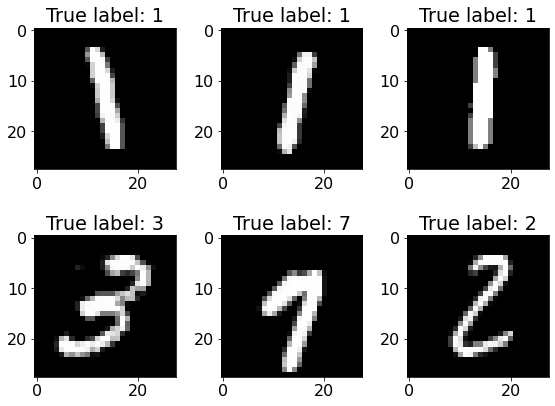

((70000, 784), (70000,))

In [3]:
#-- Plot a few examples:
N, d   = mX.shape
fig, _ = plt.subplots(2, 3, figsize=(8,6))
for ax in fig.axes:
    idx = np.random.randint(0, N)
    ax.imshow(np.reshape(mX[idx,:], (28, 28)), cmap='gray')
    ax.set_title('True label: ' + str(vY[idx]))
    
plt.tight_layout()
plt.show()

mX.shape, vY.shape

### Define the model:
![a](https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/02_DeepLearningBasics/OneHiddenLayerModel.png?raw=true)
$$\hat{\boldsymbol{y}}_{i}=\text{softmax}\left(\boldsymbol{W}_{2}\text{ReLU}\left(\boldsymbol{W}_{1}\boldsymbol{x}_{i}+\boldsymbol{b}_{1}\right)+\boldsymbol{b}_{2}\right)$$

\begin{align*}
\boldsymbol{x}\in\mathbb{R}^{784},\quad & \boldsymbol{W}_{1}\in\mathbb{R}^{d\times784},\quad\boldsymbol{W}_{2}\in\mathbb{R}^{10\times d}\\
\hat{\boldsymbol{y}}\in\mathbb{R}^{10},\quad & \boldsymbol{b}_{1}\in\mathbb{R}^{d},\qquad\boldsymbol{b}_{2}\in\mathbb{R}^{10}
\end{align*}

where $d$ is the hidden layer dimension.  
For simplicity, we denote:
$$\hat{\boldsymbol{y}}_{i}=\text{softmax}\left(\boldsymbol{z}_i\right)$$
where
$$\boldsymbol{z}_i=\boldsymbol{W}_{2}\boldsymbol{a}_{i}+\boldsymbol{b}_{2},\qquad\boldsymbol{a}_{i}=\text{ReLU}\left(\boldsymbol{W}_{1}\boldsymbol{x}_{i}+\boldsymbol{b}_{1}\right)$$

Some more definitions:
$$\boldsymbol{X}=\left[\begin{matrix}| &  & |\\
\boldsymbol{x}_{1} & \cdots & \boldsymbol{x}_{N}\\
| &  & |
\end{matrix}\right]\in\mathbb{R}^{784\times N},\qquad\hat{\boldsymbol{Y}}=\left[\begin{matrix}| &  & |\\
\hat{\boldsymbol{y}}_{1} & \cdots & \hat{\boldsymbol{y}}_{N}\\
| &  & |
\end{matrix}\right]\in\mathbb{R}^{10\times N}$$

In [4]:
def ReLU(mX):
    return np.maximum(mX, 0)

def Softmax(mX):
    mExp = np.exp(mX)
    return mExp / np.sum(mExp, axis=0)

def Model(mX, mW1, vB1, mW2, vB2):
    mA = ReLU(mW1 @ mX + vB1[:,None])
    mZ = mW2 @ mA + vB2[:,None]
    return Softmax(mZ)

###  Loss function
#### Cross entropy loss:
$$\ell\left(\boldsymbol{y}_{i},\hat{\boldsymbol{y}}_{i}\right)=-\boldsymbol{y}_{i}^{T}\log\left(\hat{\boldsymbol{y}}_{i}\right)$$

Note that if (for example) $y_i = 3$ than:
$$\boldsymbol{y}_{i}^{T}\log\left(\hat{\boldsymbol{y}}_{i}\right)=\log\left(\hat{\boldsymbol{y}}_{i}\left[3\right]\right)$$

#### Overall loss:
$$L=\frac{1}{N}\sum_{i=1}^{N}\ell_{i}=\frac{1}{N}\sum_{i=1}^{N}\ell\left(\boldsymbol{y}_{i},\hat{\boldsymbol{y}}_{i}\right)$$

In [5]:
def Loss(vY, mHatY):
    N = len(vY)
    return -np.log(mHatY[vY,range(N)]).mean()

### Gradients
The gradients of the loss functoin $L$ are:
$$\nabla_{\boldsymbol{b}_{2}}L=\frac{1}{N}\sum_{i=1}^{N}{\hat{\boldsymbol{y}}_{i}}-\boldsymbol{y}_{i}$$

$$\nabla_{\boldsymbol{W}_{2}}L=\frac{1}{N}\sum_{i=1}^{N}\left(\hat{\boldsymbol{y}}_{i}-\boldsymbol{y}_{i}\right)\boldsymbol{a}_{i}^{T}$$

$$\nabla_{\boldsymbol{b}_{1}}L=\frac{1}{N}\sum_{i=1}^{N}\boldsymbol{I}_{\boldsymbol{v}_{i}>0}\boldsymbol{W}_{2}^{T}\left(\hat{\boldsymbol{y}}_{i}-\boldsymbol{y}_{i}\right)$$

$$\nabla_{\boldsymbol{W}_{1}}L=\frac{1}{N}\sum_{i=1}^{N}\boldsymbol{I}_{\boldsymbol{v}_{i}>0}\boldsymbol{W}_{2}^{T}\left(\hat{\boldsymbol{y}}_{i}-\boldsymbol{y}_{i}\right)\boldsymbol{x}_{i}^{T}$$

where $\boldsymbol{v}_{i}=\boldsymbol{W}_{1}\boldsymbol{x}_{i}+\boldsymbol{b}_{1}$ and $\boldsymbol{I}_{\boldsymbol{v}_{i}>0}=\text{diag}\left(\mathbb{I}\left\{ \boldsymbol{v}_i>0\right\} \right)$

In [6]:
def ComputeGradients(mX, vY, mW1, vB1, mW2, vB2):
    N  = mX.shape[1]
    
    mV     = mW1 @ mX + vB1[:,None]          #-- (d, N)
    mA     = ReLU(mV)                        #-- (d, N)
    mZ     = mW2 @ mA + vB2[:,None]          #-- (10, N)
    mHatY  = np.exp(mZ)                      #-- (10, N)
    mHatY /= np.sum(mHatY, axis=0)
    
    mTemp               = mHatY              #-- (10, N)
    mTemp[vY,range(N)] -= 1
    mTemp              /= N
    
    dB2                 = mTemp.sum(axis=1)  #-- (10,)
    dW2                 = mTemp @ mA.T       #-- (10, d)
    
    mTemp               = mW2.T @ mTemp      #-- (d, N)
    mTemp[mV < 0]       = 0
    
    dB1                 = mTemp.sum(axis=1)  #-- (d,)
    dW1                 = mTemp @ mX.T       #-- (d, 784)
    
    return dW1, dB1, dW2, dB2

###  Split to train and test:

In [7]:
from sklearn.model_selection import train_test_split

Ntrain  = 60000
Ntest   = 1000
vIdx    = np.random.choice(N, Ntrain + Ntest)
mX      = mX[vIdx,:]
vY      = vY[vIdx]

mTrainX, mTestX, vTrainY, vTestY = train_test_split(mX, vY, train_size=Ntrain, test_size=Ntest)

(mTrainX.shape, 
vTrainY.shape, 
mTestX.shape,  
vTestY.shape)

((60000, 784), (60000,), (1000, 784), (1000,))

### Initialize the model:

In [8]:
def InitModel(dIn, dHidden, dOut):
    mW1 = np.random.randn(dHidden, dIn) / dIn
    vB1 = np.zeros(dHidden)
    mW2 = np.random.randn(dOut, dHidden) / dHidden
    vB2 = np.zeros(dOut)
    
    return mW1, vB1, mW2, vB2

### Apply gradient descent:

<IPython.core.display.Javascript object>


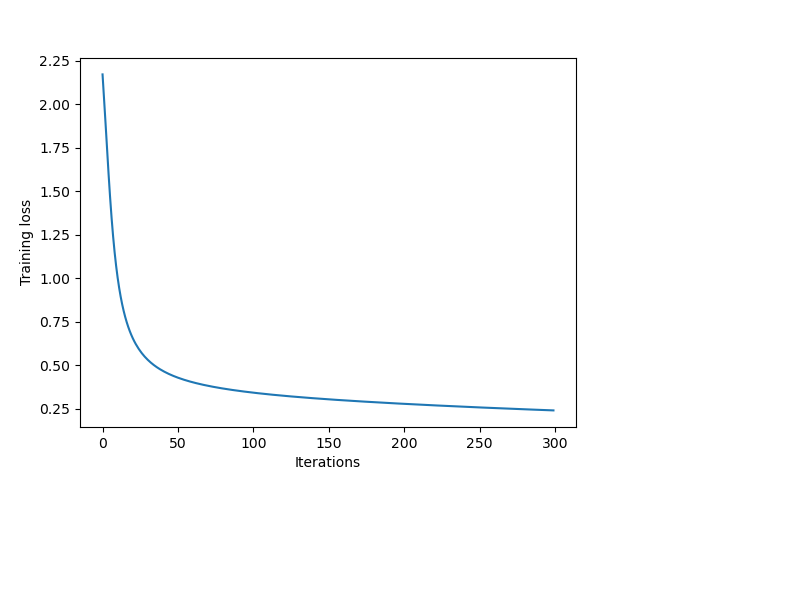

In [9]:
%matplotlib notebook
#-- Gradient descent params:
numIter = 300
µ       = 1e-3 #-- step size \ learning rate

#-- Init:
dIn                = mX.shape[1]
dHidden            = 200
dOut               = len(np.unique(vY))
mW1, vB1, mW2, vB2 = InitModel(dIn, dHidden, dOut)
    
#-- Gradient descent:
fig   = plt.figure()
vLoss = []
for ii in range(numIter):

    #-- Update weights:
    dW1, dB1, dW2, dB2  = ComputeGradients(mTrainX.T, vTrainY, mW1, vB1, mW2, vB2)
    mW1                -= µ * dW1
    vB1                -= µ * dB1
    mW2                -= µ * dW2
    vB2                -= µ * dB2

    #-- Check loss:
    mHatY               = Model(mTrainX.T, mW1, vB1, mW2, vB2)
    loss                = Loss(vTrainY, mHatY)
    vLoss.append(loss)
    
    #-- Display:
    print('Iteration: ', ii, '. loss = ', loss, '\r', end='')
    plt.cla()
    plt.plot(vLoss)
    plt.xlabel('Iterations')
    plt.ylabel('Training loss')
    fig.canvas.draw()
    plt.pause(1e-20)


###  Check model performance:

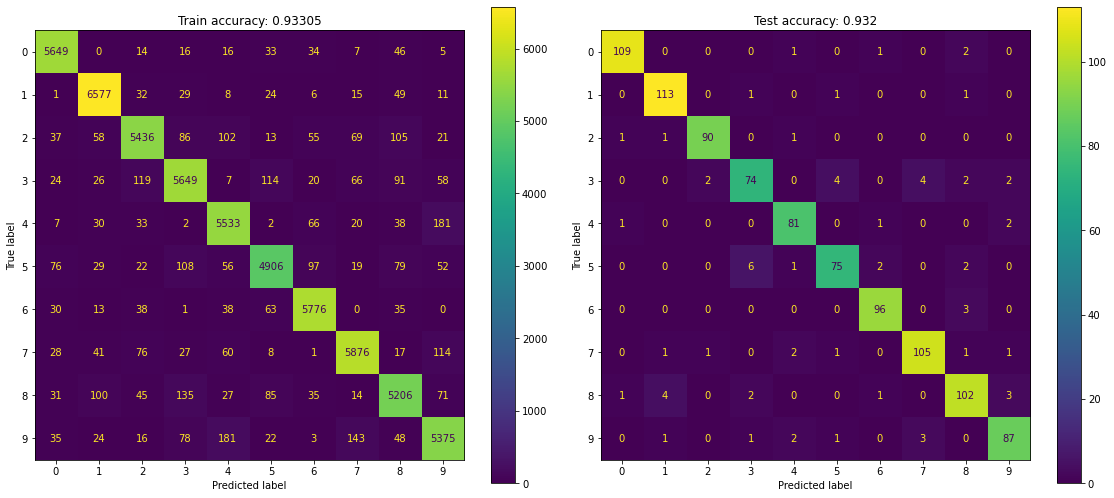

In [10]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#-- Apply model to data:
mHatTrainY = Model(mTrainX.T, mW1, vB1, mW2, vB2)
mHatTestY  = Model(mTestX.T,  mW1, vB1, mW2, vB2)
vHatTrainY = np.argmax(mHatTrainY, axis=0)
vHatTestY  = np.argmax(mHatTestY,  axis=0)

#-- Plot condusion matrices:
mTrainConfusion = confusion_matrix(vTrainY, vHatTrainY)
mTestConfusion  = confusion_matrix(vTestY,  vHatTestY)

_, ax = plt.subplots(1, 2, figsize=(16,7))
ConfusionMatrixDisplay(mTrainConfusion, display_labels=range(10)).plot(values_format='g', ax=ax[0])
ConfusionMatrixDisplay(mTestConfusion,  display_labels=range(10)).plot(values_format='g', ax=ax[1])
ax[0].set_title('Train accuracy: ' + str(np.mean(vTrainY == vHatTrainY)))
ax[1].set_title('Test accuracy: '  + str(np.mean(vTestY  == vHatTestY)))
plt.tight_layout()
plt.show()